In [1]:
# connecting to Google Drive
import os.path
from google.colab import drive


def ensure_drive():
  if not os.path.exists('/content/drive/My Drive'):
    drive.mount('/content/drive', force_remount=True)
    
ensure_drive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g5HiJt62HEpupsHZJNG1h5yJVZZg-F8K8CZIciz8aMrKUaMmxjP9u0
Mounted at /content/drive


In [2]:
# declaring some data locations
DRIVE_STORAGE_PATH = '/content/drive/My Drive/SPEECH'

SPEECH_DATA = "/content/drive/My Drive/speech_data"

print("Cool!")

Cool!


*Let the game begin...*

In [3]:
!pip install tensorflow.io


     |████████████████████████████████| 25.3MB 173kB/s 


In [4]:
# importing required packages

import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops
print('DONE!')

DONE!


In [5]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [6]:
# list of folders we want to process in the speech_data folder
command_words = [
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
]
nonsense_words = [
    'stop',
    'go',
    'on',
    'off',
    'up',
    'down',
    'learn',
    'yes',
    'no',
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'follow',
    'tree',
    'bed',
    'bird',
    'cat',
    'dog',
    'happy',
    'house',
    'marvin',
    'sheila',
    'visual',
    'wow',
]

In [7]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.experimental.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()

def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True

In [8]:
# A function to get a spectogram from each audio file

def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [9]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [10]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [11]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, label, repeat=1):
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samplesw
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the command words
for word in tqdm(command_words, desc="Processing words"):
    if '_' not in word:
        repeat = 40 if word in ('red','blue') else 20
        process_word(word, command_words.index(word), repeat=repeat)
        
# all the nonsense words
for word in tqdm(nonsense_words, desc="Processing words"):
    if '_' not in word:
        process_word(word, command_words.index('_invalid'), repeat=1)

print(len(train), len(test), len(validate))


1714 303 183


In [13]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))
    
print(len(train), len(test), len(validate))


6828 948 820


In [14]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))

In [15]:
print(len(train), len(test), len(validate))

6828 948 820


In [16]:
# randomise the training samples
np.random.shuffle(train)

In [17]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [18]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [20]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [21]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

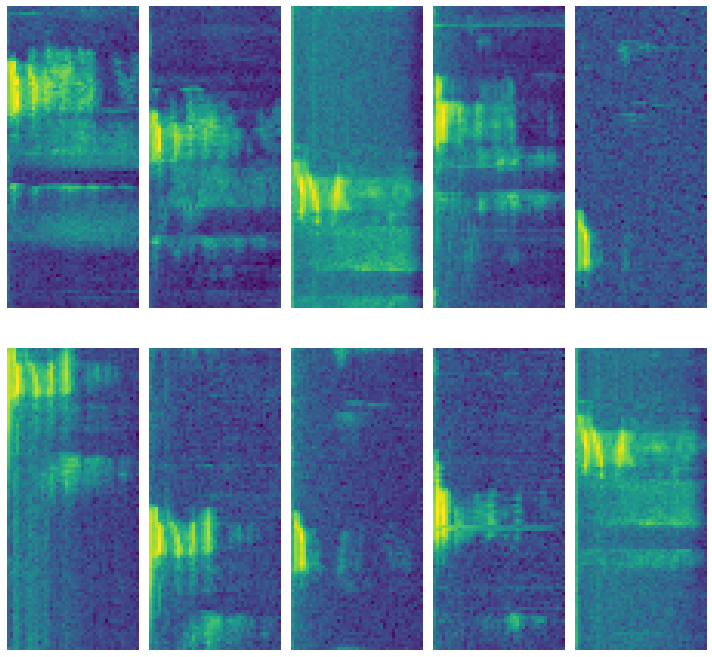

In [22]:
word_index = command_words.index("left")

X_left = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_left[:10], IMG_WIDTH, IMG_HEIGHT)

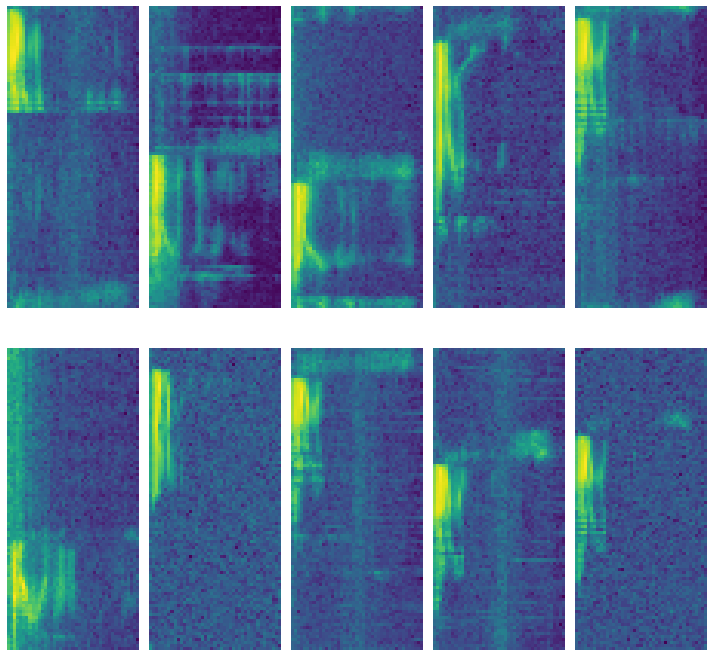

In [23]:
word_index = command_words.index("forward")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)

# Training

This treats the spectrograms of the words like images

In [24]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [25]:
# Load the TensorBoard notebook extension - if you want it inline - this can be a bit flaky...
# %load_ext tensorboard
# %reload_ext tensorboard

In [26]:
# clear out any old logs
!rm -rf ./logs/ 

In [27]:
# launch tensorboard using this command
# %tensorboard --logdir logs

In [28]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [29]:
# List of the words in categorical order
command_words = [
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
]

In [30]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

In [31]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

(array([ 340.,  380.,  240.,  320., 5548.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

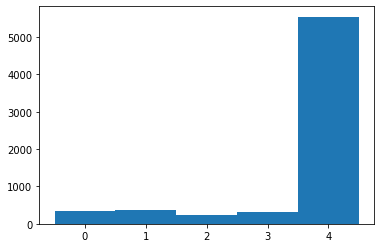

In [32]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(command_words)+1), align='left')

In [34]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3 4] [ 340  380  240  320 5548]


{'_invalid': 5548, 'backward': 380, 'forward': 340, 'left': 240, 'right': 320}

In [36]:
Y_train = tf.one_hot(Y_train_cats, len(command_words))
Y_validate = tf.one_hot(Y_validate_cats, len(command_words))
Y_test = tf.one_hot(Y_test_cats, len(command_words))

In [39]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [40]:
model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(
        80,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dropout(0.1),
    Dense(
        len(command_words), 
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 99, 43, 4)         40        
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)         0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 49, 21, 4)         148       
_________________________________________________________________
max_pooling3 (MaxPooling2D)  (None, 24, 10, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 960)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 80)               

In [42]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [43]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model

In [44]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/10
213/213 [==============================] - 14s 62ms/step - loss: 0.9225 - accuracy: 0.7899 - val_loss: 0.4950 - val_accuracy: 0.8646
INFO:tensorflow:Assets written to: checkpoint.model/assets
Epoch 2/10
213/213 [==============================] - 13s 60ms/step - loss: 0.4862 - accuracy: 0.8510 - val_loss: 0.5692 - val_accuracy: 0.8451
Epoch 3/10
213/213 [==============================] - 13s 61ms/step - loss: 0.3940 - accuracy: 0.8912 - val_loss: 0.3985 - val_accuracy: 0.8915
INFO:tensorflow:Assets written to: checkpoint.model/assets
Epoch 4/10
213/213 [==============================] - 13s 60ms/step - loss: 0.3065 - accuracy: 0.9261 - val_loss: 0.3695 - val_accuracy: 0.9085
INFO:tensorflow:Assets written to: checkpoint.model/assets
Epoch 5/10
213/213 [==============================] - 13s 60ms/step - loss: 0.2495 - accuracy: 0.9408 - val_loss: 0.3258 - val_accuracy: 0.9354
INFO:tensorflow:Assets written to: checkpoint.model/assets
Epoch 6/10
213/213 [========================

In [45]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


# Testing the Model

In [46]:
model2 =  keras.models.load_model("trained.model")

In [50]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

8/8 [==============================] - 1s 76ms/step - loss: 0.2296 - accuracy: 0.9335


In [51]:
predictions = model2.predict(X_test, 128)

In [52]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

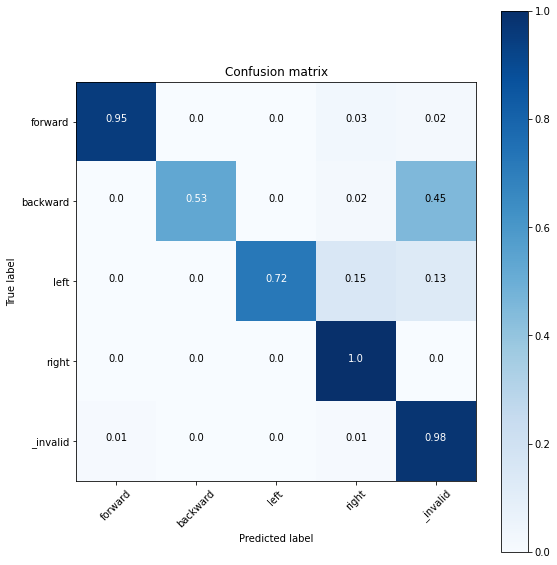

In [53]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

# Fully train the model

In [54]:
batch_size = 30
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(len(complete_train_X)).batch(batch_size)

In [55]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
286/286 [==============================] - 17s 57ms/step - loss: 0.1369 - accuracy: 0.9758
Epoch 2/5
286/286 [==============================] - 16s 56ms/step - loss: 0.1317 - accuracy: 0.9776
Epoch 3/5
286/286 [==============================] - 16s 57ms/step - loss: 0.1211 - accuracy: 0.9836
Epoch 4/5
286/286 [==============================] - 16s 56ms/step - loss: 0.1173 - accuracy: 0.9829
Epoch 5/5
286/286 [==============================] - 16s 56ms/step - loss: 0.1120 - accuracy: 0.9836


In [61]:
model2.save("fully_trained.model")

INFO:tensorflow:Assets written to: fully_trained.model/assets


In [63]:
results = model2.evaluate(complete_train_X, tf.cast(complete_train_Y, tf.float32), batch_size=128)

68/68 [==============================] - 6s 87ms/step - loss: 0.0934 - accuracy: 0.9935


In [64]:
predictions = model2.predict(complete_train_X, 128)


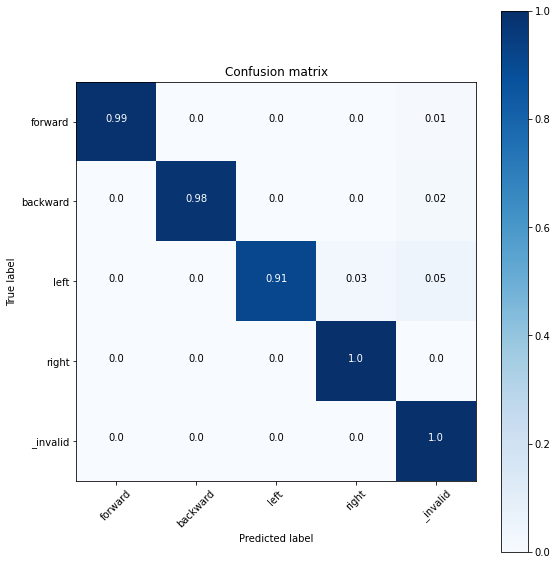

In [65]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(complete_train_Y, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)


# Converting a trained model to tflite
https://www.tensorflow.org/lite/microcontrollers/build_convert#model_conversion

# Convert model to tflite

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

X_train = training_spectrogram['X']
X_validate = validation_spectrogram['X']
X_test = test_spectrogram['X']

complete_train_X = np.concatenate((X_train, X_validate, X_test))
# complete_train_X = X_validate

In [ ]:
converter2 = tf.lite.TFLiteConverter.from_saved_model("fully_trained.model")
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(0, len(complete_train_X), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [complete_train_X[i:i+100]]
converter2.representative_dataset = representative_dataset_gen
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("/content/drive/My Drive/SPEECH/converted_model.tflite", "wb").write(tflite_quant_model)

# To convert to C++
This will run a command line too to convert out tflite model into C code.

In [ ]:
!xxd -i converted_model.tflite > model_data.cc